# Generating Super-Resolution Images

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch10_Diffusion/ec10_C_superresolution/superresolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [ ]:
# !pip install deeplay  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example to increase the resolution of microscopy images using a diffusion model.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 10-C from the book  

**Deep Learning Crash Course**  
Giovanni Volpe, Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo  
No Starch Press, San Francisco (CA), 2026  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Downloading the BioSR Dataset

In [1]:
import os

if not os.path.exists("biosr_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/biosr_dataset")

## Managing the Dataset

In [2]:
import torch
from tifffile import tifffile as tiff

class BioSRDataset(torch.utils.data.Dataset):
    """Dataset class to load the BioSR dataset."""

    def __init__(self, lr_dir, hr_dir, transform):
        """Initialize dataset."""
        self.lr_dir, self.hr_dir, self.transform = lr_dir, hr_dir, transform
        self.files = [file for file in os.listdir(self.lr_dir)
                      if file.endswith(".tif")]

    def __len__(self):
        """Return the number of image pairs."""
        return len(self.files)

    def __getitem__(self, index):
        """Get a low-resolution--high-resolution image pair."""
        lr_image = tiff.imread(os.path.join(self.lr_dir, self.files[index]))
        hr_image = tiff.imread(os.path.join(self.hr_dir, self.files[index]))
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        return lr_image, hr_image        

## Preprocessing the Images

In [3]:
from torchvision.transforms import Compose, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

## Creating the Training and Testing Datasets

Create the datasets ...

In [4]:
root = os.path.join("biosr_dataset", "BioSR", "Microtubules")
train_set = BioSRDataset(lr_dir=os.path.join(root, "training_wf"),
                         hr_dir=os.path.join(root, "training_gt"),
                         transform=transform)
test_set = BioSRDataset(lr_dir=os.path.join(root, "test_wf", "level_09"),
                        hr_dir=os.path.join(root, "test_gt"),
                        transform=transform)

... and plot some low-resolution and high-resolution images.

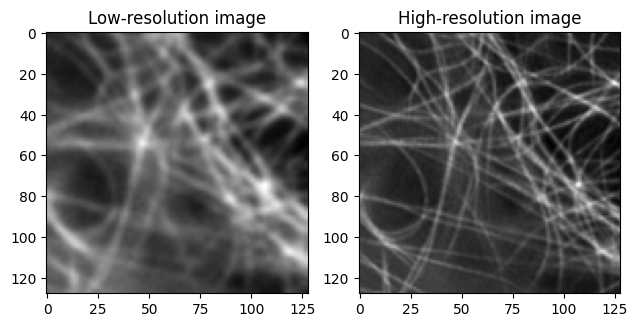

In [5]:
import matplotlib.pyplot as plt
import numpy as np

lr_image, hr_image = train_set[np.random.randint(0, len(train_set))]

plt.subplot(1, 2, 1)
plt.imshow(lr_image.permute(1, 2, 0), cmap="gray")
plt.title("Low-resolution image")

plt.subplot(1, 2, 2)
plt.imshow(hr_image.permute(1, 2, 0), cmap="gray")
plt.title("High-resolution image")

plt.tight_layout()
plt.show()

## Adapting the Diffusion Process for Super-Resolution

Define the device on which the computations are performed ...

In [6]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Selected device: {device}")

Selected device: mps


... implement the reverse diffusion for super-resolution ...

In [7]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilistic model (DDPM)."""

    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.img_size, self.device = steps, img_size, device
        self.beta = torch.linspace(beta_start, beta_end, steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def reverse_diffusion(self, model, n_images, n_channels, pos_enc_dim,
                          pos_enc_func, input_image, fix_noise=None,
                          save_time_steps=None):
        """Reverse diffusion process."""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size),
                ).to(self.device)

            denoised_images = []
            for i in tqdm(reversed(range(0, self.steps)),
                        desc="U-Net inference", total=self.steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = (pos_enc_func(t.unsqueeze(1), pos_enc_dim)
                            .to(self.device))
                pred_noise = model(
                    torch.cat((input_image.to(self.device), x), dim=1),
                    t=t_pos_enc,
                )
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha) 
                    * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar))
                       * pred_noise)
                    + torch.sqrt(1 - alpha) * noise)
                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images).swapaxes(0, 1)
            return denoised_images

## Defining the Conditional Attention U-Net

In [8]:
import deeplay as dl

pos_enc_dim = 256

unet = dl.AttentionUNet(
    in_channels=2, channels=[32, 64, 128], base_channels=[256, 256],
    channel_attention=[False, False, False], out_channels=1,
    position_embedding_dim=pos_enc_dim,
).build().to(device)

## Training the Conditional Diffusion Model

Define the data loaders ...

In [9]:
train_loader = dl.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = dl.DataLoader(test_set, batch_size=64, shuffle=False)

... instantiate the diffusion class ...

In [10]:
diffusion = Diffusion(steps=2000, img_size=128, beta_start=1e-6, beta_end=0.01)

... define the loss function ...

In [11]:
criterion = torch.nn.L1Loss()

... define the position encoding function ...

In [12]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10_000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    angle = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_sin, pos_enc_cos = torch.sin(angle), torch.cos(angle)
    pos_enc = torch.cat([pos_enc_sin, pos_enc_cos], dim=-1)
    return pos_enc

... define the optimizer ...

In [13]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

... implement the function to prepare the data for super-resolution task ...

In [14]:
def prepare_data(input_image, target_image, steps=2000, device=device):
    """Prepare data."""
    batch_size = input_image.shape[0]
    t = torch.randint(low=0, high=steps, size=(batch_size,)).to(device)
    input_image, target_image = input_image.to(device), target_image.to(device)
    x_t, noise = diffusion.forward_diffusion(target_image, t)
    x_t = torch.cat((input_image, x_t), dim=1)
    t_pos_enc = positional_encoding(t.unsqueeze(1), pos_enc_dim)
    return x_t.to(device), t_pos_enc.to(device), noise.to(device)

... and train the network.


Epoch 1/30
__________
Batch 1/642: Train loss: 0.7891
Batch 101/642: Train loss: 0.1314
Batch 201/642: Train loss: 0.0883
Batch 301/642: Train loss: 0.0685
Batch 401/642: Train loss: 0.0782
Batch 501/642: Train loss: 0.0765
Batch 601/642: Train loss: 0.0660
----------
Epoch 1/30 : Train loss: 0.1191, Time taken: 0:07:01.848258


U-Net inference: 100%|██████████| 2000/2000 [00:16<00:00, 120.11it/s]


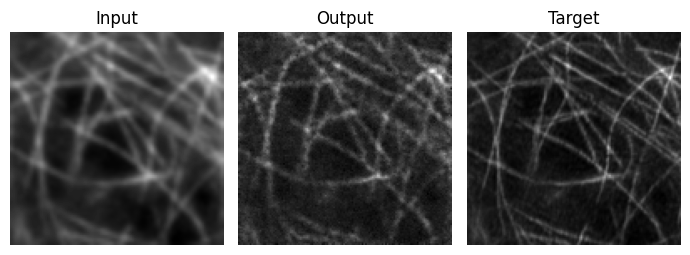


Epoch 2/30
__________
Batch 1/642: Train loss: 0.0725
Batch 101/642: Train loss: 0.0456
Batch 201/642: Train loss: 0.0663
Batch 301/642: Train loss: 0.0608
Batch 401/642: Train loss: 0.0602
Batch 501/642: Train loss: 0.0486
Batch 601/642: Train loss: 0.0570
----------
Epoch 2/30 : Train loss: 0.0677, Time taken: 0:07:04.300880


U-Net inference: 100%|██████████| 2000/2000 [00:15<00:00, 129.00it/s]


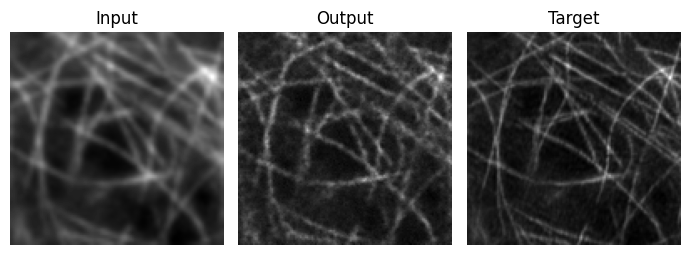


Epoch 3/30
__________
Batch 1/642: Train loss: 0.0968
Batch 101/642: Train loss: 0.0745
Batch 201/642: Train loss: 0.0550
Batch 301/642: Train loss: 0.0479
Batch 401/642: Train loss: 0.0479
Batch 501/642: Train loss: 0.0544
Batch 601/642: Train loss: 0.0708
----------
Epoch 3/30 : Train loss: 0.0617, Time taken: 0:07:05.104781


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 144.35it/s]


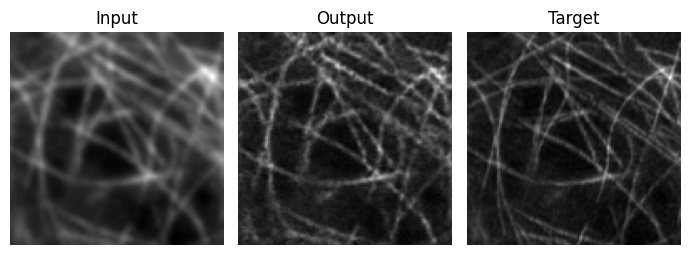


Epoch 4/30
__________
Batch 1/642: Train loss: 0.0478
Batch 101/642: Train loss: 0.0602
Batch 201/642: Train loss: 0.0477
Batch 301/642: Train loss: 0.0653
Batch 401/642: Train loss: 0.0604
Batch 501/642: Train loss: 0.0651
Batch 601/642: Train loss: 0.0411
----------
Epoch 4/30 : Train loss: 0.0587, Time taken: 0:07:04.385432


U-Net inference: 100%|██████████| 2000/2000 [00:15<00:00, 130.48it/s]


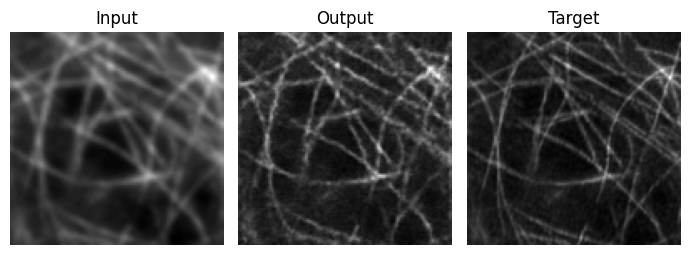


Epoch 5/30
__________
Batch 1/642: Train loss: 0.0619
Batch 101/642: Train loss: 0.0676
Batch 201/642: Train loss: 0.0428
Batch 301/642: Train loss: 0.0531
Batch 401/642: Train loss: 0.0552
Batch 501/642: Train loss: 0.0736
Batch 601/642: Train loss: 0.0759
----------
Epoch 5/30 : Train loss: 0.0561, Time taken: 0:07:02.668630


U-Net inference: 100%|██████████| 2000/2000 [00:15<00:00, 133.16it/s]


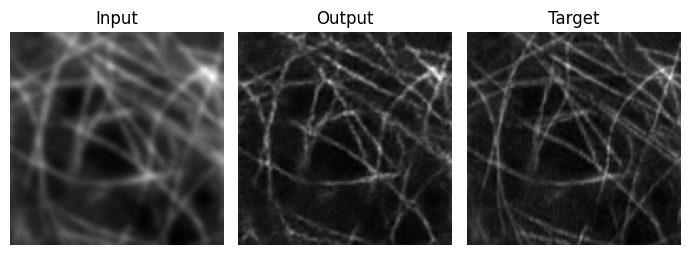


Epoch 6/30
__________
Batch 1/642: Train loss: 0.0401
Batch 101/642: Train loss: 0.0487
Batch 201/642: Train loss: 0.0537
Batch 301/642: Train loss: 0.0615
Batch 401/642: Train loss: 0.0685
Batch 501/642: Train loss: 0.0422
Batch 601/642: Train loss: 0.0749
----------
Epoch 6/30 : Train loss: 0.0550, Time taken: 0:07:04.034211


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.44it/s]


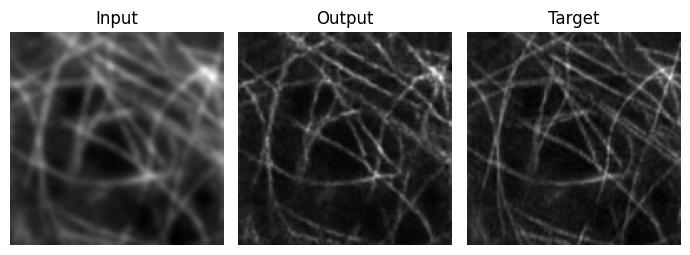


Epoch 7/30
__________
Batch 1/642: Train loss: 0.0391
Batch 101/642: Train loss: 0.0517
Batch 201/642: Train loss: 0.0581
Batch 301/642: Train loss: 0.0592
Batch 401/642: Train loss: 0.0561
Batch 501/642: Train loss: 0.0502
Batch 601/642: Train loss: 0.0646
----------
Epoch 7/30 : Train loss: 0.0545, Time taken: 0:07:01.301140


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.34it/s]


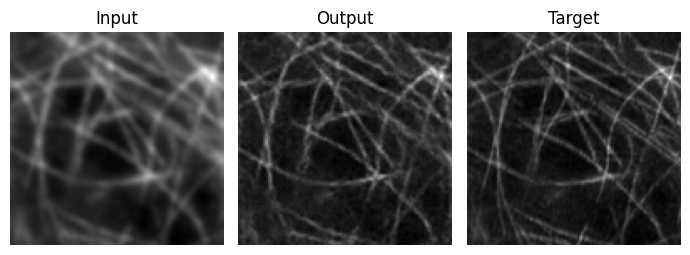


Epoch 8/30
__________
Batch 1/642: Train loss: 0.0410
Batch 101/642: Train loss: 0.0430
Batch 201/642: Train loss: 0.0518
Batch 301/642: Train loss: 0.0690
Batch 401/642: Train loss: 0.0659
Batch 501/642: Train loss: 0.0457
Batch 601/642: Train loss: 0.0344
----------
Epoch 8/30 : Train loss: 0.0532, Time taken: 0:07:01.696687


U-Net inference: 100%|██████████| 2000/2000 [00:14<00:00, 133.58it/s]


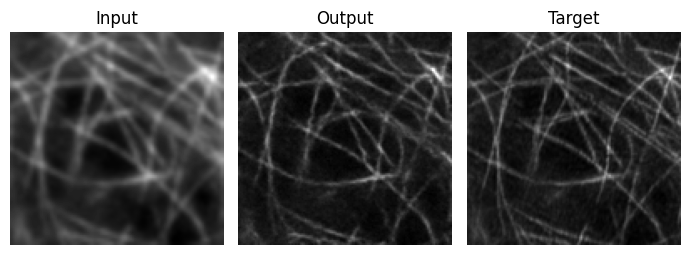


Epoch 9/30
__________
Batch 1/642: Train loss: 0.0563
Batch 101/642: Train loss: 0.0657
Batch 201/642: Train loss: 0.0730
Batch 301/642: Train loss: 0.0684
Batch 401/642: Train loss: 0.0519
Batch 501/642: Train loss: 0.0572
Batch 601/642: Train loss: 0.0361
----------
Epoch 9/30 : Train loss: 0.0529, Time taken: 0:06:54.895027


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.88it/s]


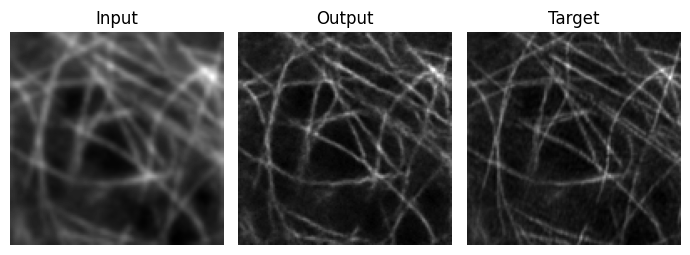


Epoch 10/30
__________
Batch 1/642: Train loss: 0.0359
Batch 101/642: Train loss: 0.0465
Batch 201/642: Train loss: 0.0447
Batch 301/642: Train loss: 0.0409
Batch 401/642: Train loss: 0.0582
Batch 501/642: Train loss: 0.0581
Batch 601/642: Train loss: 0.0415
----------
Epoch 10/30 : Train loss: 0.0514, Time taken: 0:07:00.239370


U-Net inference: 100%|██████████| 2000/2000 [00:15<00:00, 132.86it/s]


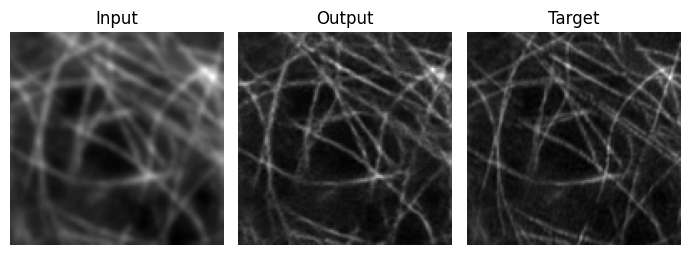


Epoch 11/30
__________
Batch 1/642: Train loss: 0.0475
Batch 101/642: Train loss: 0.0508
Batch 201/642: Train loss: 0.0508
Batch 301/642: Train loss: 0.0579
Batch 401/642: Train loss: 0.0500
Batch 501/642: Train loss: 0.0474
Batch 601/642: Train loss: 0.0720
----------
Epoch 11/30 : Train loss: 0.0513, Time taken: 0:06:57.372433


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.88it/s]


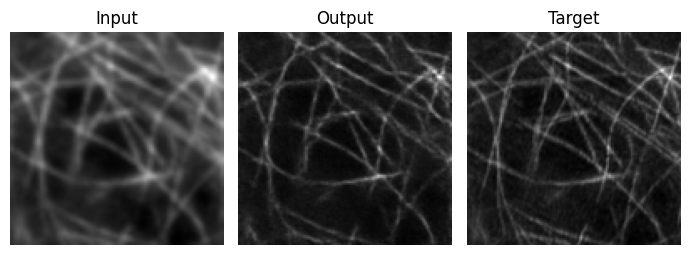


Epoch 12/30
__________
Batch 1/642: Train loss: 0.0555
Batch 101/642: Train loss: 0.0539
Batch 201/642: Train loss: 0.0472
Batch 301/642: Train loss: 0.0650
Batch 401/642: Train loss: 0.0551
Batch 501/642: Train loss: 0.0424
Batch 601/642: Train loss: 0.0572
----------
Epoch 12/30 : Train loss: 0.0514, Time taken: 0:07:02.454268


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 144.89it/s]


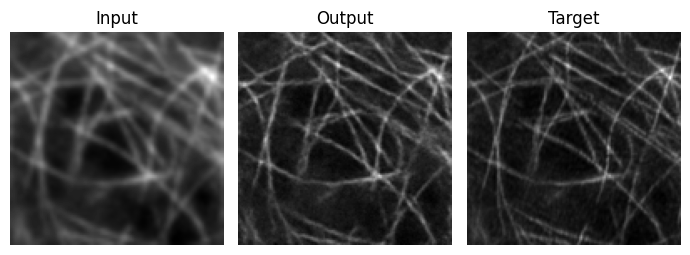


Epoch 13/30
__________
Batch 1/642: Train loss: 0.0549
Batch 101/642: Train loss: 0.0541
Batch 201/642: Train loss: 0.0453
Batch 301/642: Train loss: 0.0451
Batch 401/642: Train loss: 0.0582
Batch 501/642: Train loss: 0.0376
Batch 601/642: Train loss: 0.0393
----------
Epoch 13/30 : Train loss: 0.0501, Time taken: 0:07:02.243550


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.49it/s]


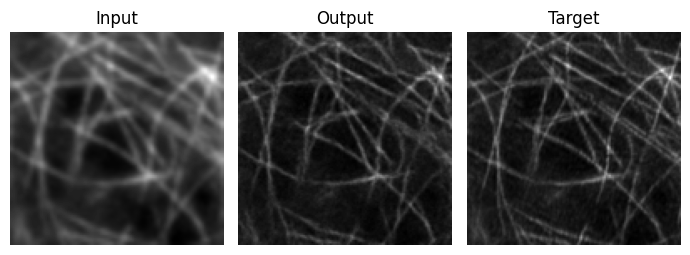


Epoch 14/30
__________
Batch 1/642: Train loss: 0.0570
Batch 101/642: Train loss: 0.0495
Batch 201/642: Train loss: 0.0450
Batch 301/642: Train loss: 0.0398
Batch 401/642: Train loss: 0.0608
Batch 501/642: Train loss: 0.0369
Batch 601/642: Train loss: 0.0495
----------
Epoch 14/30 : Train loss: 0.0496, Time taken: 0:07:01.857597


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 143.63it/s]


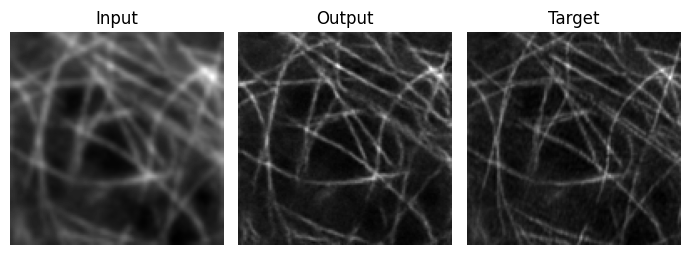


Epoch 15/30
__________
Batch 1/642: Train loss: 0.0695
Batch 101/642: Train loss: 0.0438
Batch 201/642: Train loss: 0.0463
Batch 301/642: Train loss: 0.0478
Batch 401/642: Train loss: 0.0636
Batch 501/642: Train loss: 0.0474
Batch 601/642: Train loss: 0.0738
----------
Epoch 15/30 : Train loss: 0.0488, Time taken: 0:07:02.609594


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 144.19it/s]


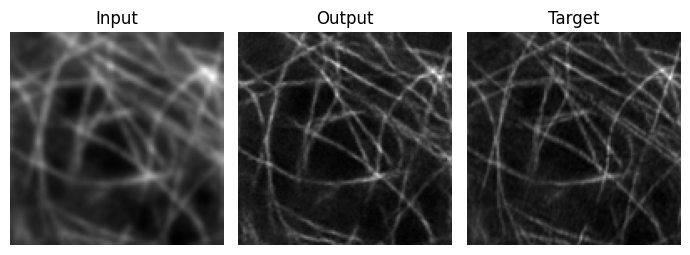


Epoch 16/30
__________
Batch 1/642: Train loss: 0.0633
Batch 101/642: Train loss: 0.0310
Batch 201/642: Train loss: 0.0553
Batch 301/642: Train loss: 0.0464
Batch 401/642: Train loss: 0.0468
Batch 501/642: Train loss: 0.0468
Batch 601/642: Train loss: 0.0379
----------
Epoch 16/30 : Train loss: 0.0487, Time taken: 0:07:02.932247


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 144.67it/s]


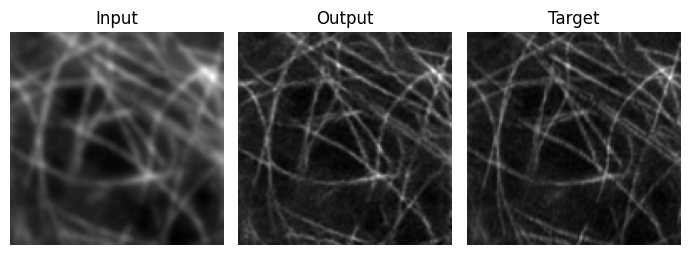


Epoch 17/30
__________
Batch 1/642: Train loss: 0.0302
Batch 101/642: Train loss: 0.0595
Batch 201/642: Train loss: 0.0362
Batch 301/642: Train loss: 0.0524
Batch 401/642: Train loss: 0.0395
Batch 501/642: Train loss: 0.0642
Batch 601/642: Train loss: 0.0534
----------
Epoch 17/30 : Train loss: 0.0482, Time taken: 0:07:03.948996


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 144.01it/s]


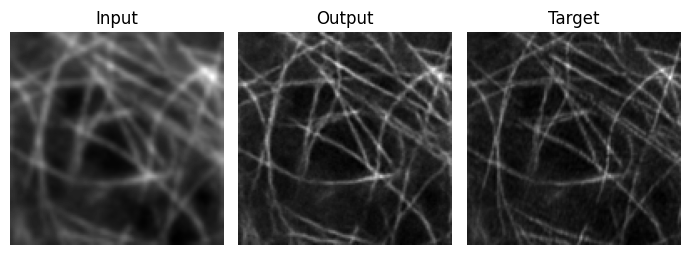


Epoch 18/30
__________
Batch 1/642: Train loss: 0.0507
Batch 101/642: Train loss: 0.0373
Batch 201/642: Train loss: 0.0420
Batch 301/642: Train loss: 0.0417
Batch 401/642: Train loss: 0.0451
Batch 501/642: Train loss: 0.0280
Batch 601/642: Train loss: 0.0425
----------
Epoch 18/30 : Train loss: 0.0480, Time taken: 0:07:02.694003


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 147.68it/s]


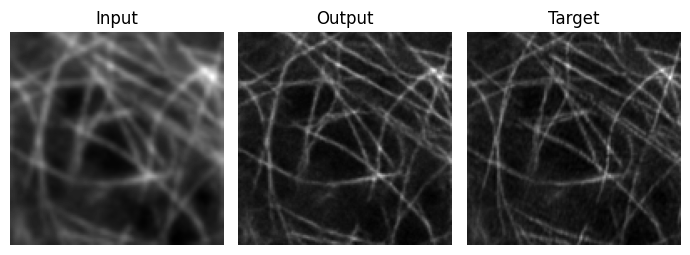


Epoch 19/30
__________
Batch 1/642: Train loss: 0.0427
Batch 101/642: Train loss: 0.0758
Batch 201/642: Train loss: 0.0295
Batch 301/642: Train loss: 0.0317
Batch 401/642: Train loss: 0.0543
Batch 501/642: Train loss: 0.0333
Batch 601/642: Train loss: 0.0564
----------
Epoch 19/30 : Train loss: 0.0484, Time taken: 0:07:06.266159


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.33it/s]


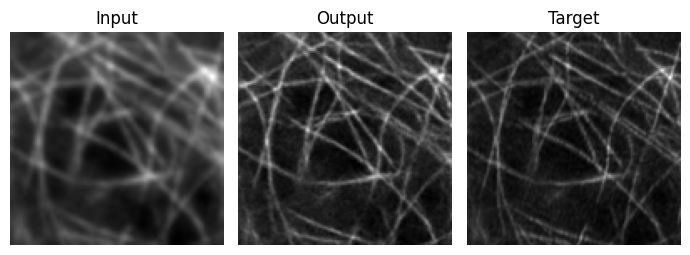


Epoch 20/30
__________
Batch 1/642: Train loss: 0.0623
Batch 101/642: Train loss: 0.0605
Batch 201/642: Train loss: 0.0482
Batch 301/642: Train loss: 0.0600
Batch 401/642: Train loss: 0.0602
Batch 501/642: Train loss: 0.0423
Batch 601/642: Train loss: 0.0378
----------
Epoch 20/30 : Train loss: 0.0481, Time taken: 0:07:04.491295


U-Net inference: 100%|██████████| 2000/2000 [00:14<00:00, 135.79it/s]


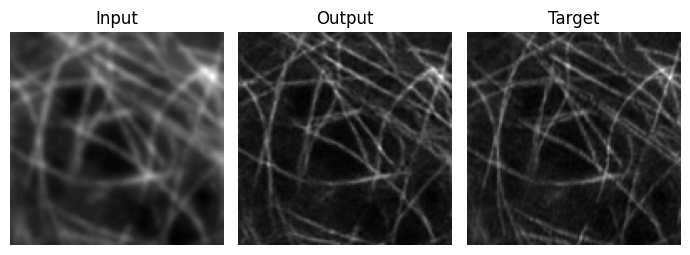


Epoch 21/30
__________
Batch 1/642: Train loss: 0.0778
Batch 101/642: Train loss: 0.0341
Batch 201/642: Train loss: 0.0493
Batch 301/642: Train loss: 0.0448
Batch 401/642: Train loss: 0.0341
Batch 501/642: Train loss: 0.0407
Batch 601/642: Train loss: 0.0593
----------
Epoch 21/30 : Train loss: 0.0468, Time taken: 0:07:04.970241


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.70it/s]


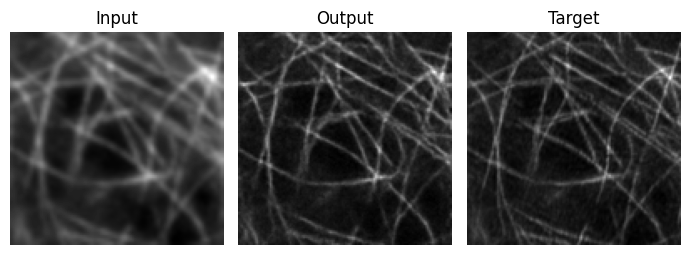


Epoch 22/30
__________
Batch 1/642: Train loss: 0.0483
Batch 101/642: Train loss: 0.0295
Batch 201/642: Train loss: 0.0426
Batch 301/642: Train loss: 0.0405
Batch 401/642: Train loss: 0.0367
Batch 501/642: Train loss: 0.0519
Batch 601/642: Train loss: 0.0520
----------
Epoch 22/30 : Train loss: 0.0469, Time taken: 0:07:08.194744


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.09it/s]


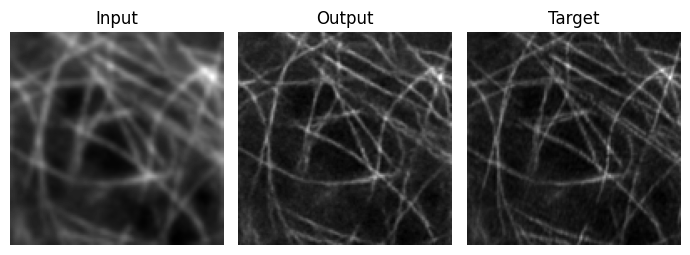


Epoch 23/30
__________
Batch 1/642: Train loss: 0.0475
Batch 101/642: Train loss: 0.0320
Batch 201/642: Train loss: 0.0618
Batch 301/642: Train loss: 0.0501
Batch 401/642: Train loss: 0.0589
Batch 501/642: Train loss: 0.0602
Batch 601/642: Train loss: 0.0384
----------
Epoch 23/30 : Train loss: 0.0476, Time taken: 0:07:08.380648


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.30it/s]


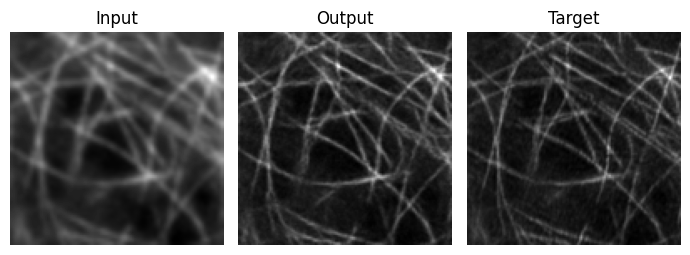


Epoch 24/30
__________
Batch 1/642: Train loss: 0.0432
Batch 101/642: Train loss: 0.0342
Batch 201/642: Train loss: 0.0479
Batch 301/642: Train loss: 0.0543
Batch 401/642: Train loss: 0.0455
Batch 501/642: Train loss: 0.0530
Batch 601/642: Train loss: 0.0524
----------
Epoch 24/30 : Train loss: 0.0478, Time taken: 0:07:08.705967


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.14it/s]


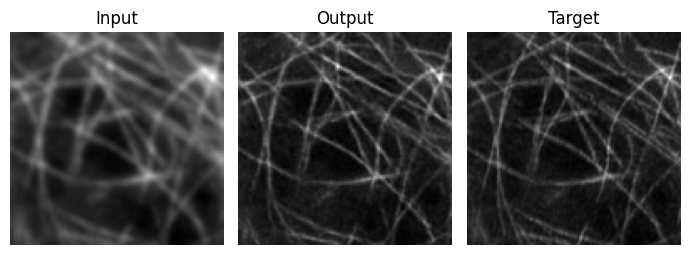


Epoch 25/30
__________
Batch 1/642: Train loss: 0.0631
Batch 101/642: Train loss: 0.0382
Batch 201/642: Train loss: 0.0265
Batch 301/642: Train loss: 0.0426
Batch 401/642: Train loss: 0.0657
Batch 501/642: Train loss: 0.0305
Batch 601/642: Train loss: 0.0414
----------
Epoch 25/30 : Train loss: 0.0458, Time taken: 0:07:08.848147


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 147.19it/s]


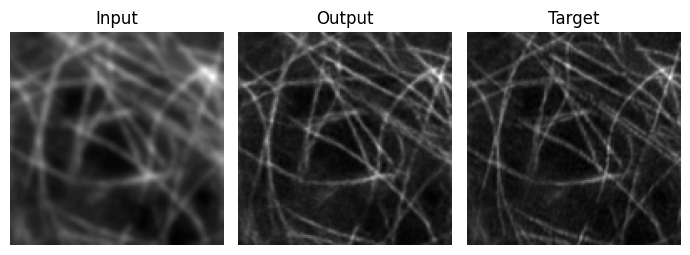


Epoch 26/30
__________
Batch 1/642: Train loss: 0.0425
Batch 101/642: Train loss: 0.0380
Batch 201/642: Train loss: 0.0498
Batch 301/642: Train loss: 0.0438
Batch 401/642: Train loss: 0.0489
Batch 501/642: Train loss: 0.0330
Batch 601/642: Train loss: 0.0447
----------
Epoch 26/30 : Train loss: 0.0461, Time taken: 0:07:09.344741


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.82it/s]


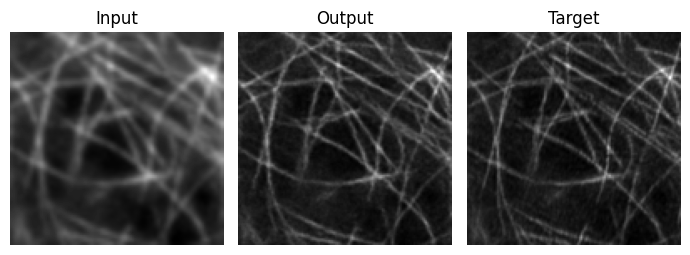


Epoch 27/30
__________
Batch 1/642: Train loss: 0.0387
Batch 101/642: Train loss: 0.0426
Batch 201/642: Train loss: 0.0360
Batch 301/642: Train loss: 0.0472
Batch 401/642: Train loss: 0.0614
Batch 501/642: Train loss: 0.0591
Batch 601/642: Train loss: 0.0506
----------
Epoch 27/30 : Train loss: 0.0464, Time taken: 0:07:09.229287


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.12it/s]


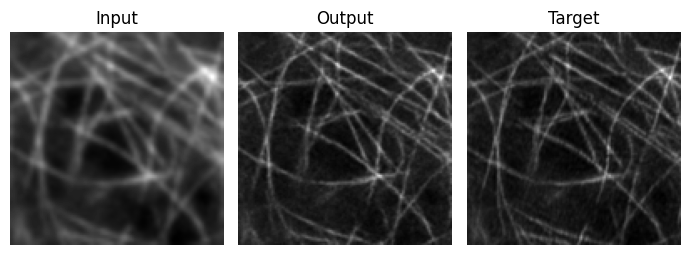


Epoch 28/30
__________
Batch 1/642: Train loss: 0.0546
Batch 101/642: Train loss: 0.0373
Batch 201/642: Train loss: 0.0444
Batch 301/642: Train loss: 0.0406
Batch 401/642: Train loss: 0.0588
Batch 501/642: Train loss: 0.0515
Batch 601/642: Train loss: 0.0329
----------
Epoch 28/30 : Train loss: 0.0457, Time taken: 0:07:10.168740


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.57it/s]


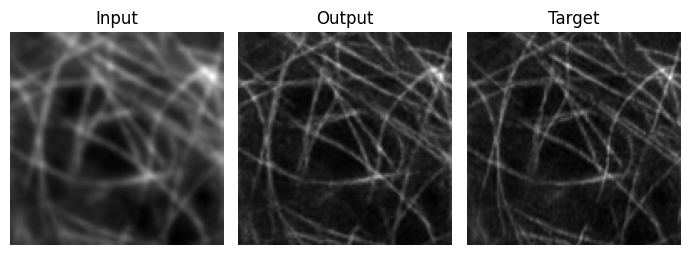


Epoch 29/30
__________
Batch 1/642: Train loss: 0.0519
Batch 101/642: Train loss: 0.0377
Batch 201/642: Train loss: 0.0526
Batch 301/642: Train loss: 0.0414
Batch 401/642: Train loss: 0.0564
Batch 501/642: Train loss: 0.0389
Batch 601/642: Train loss: 0.0377
----------
Epoch 29/30 : Train loss: 0.0462, Time taken: 0:07:09.291536


U-Net inference: 100%|██████████| 2000/2000 [00:15<00:00, 131.59it/s]


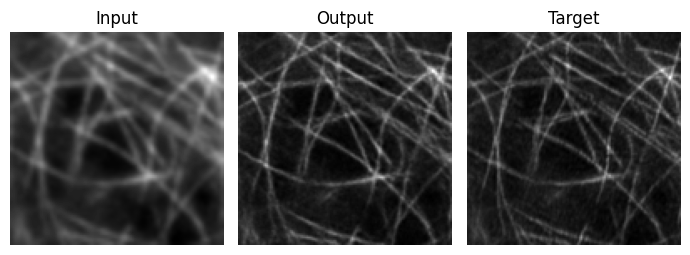


Epoch 30/30
__________
Batch 1/642: Train loss: 0.0520
Batch 101/642: Train loss: 0.0531
Batch 201/642: Train loss: 0.0468
Batch 301/642: Train loss: 0.0537
Batch 401/642: Train loss: 0.0535
Batch 501/642: Train loss: 0.0517
Batch 601/642: Train loss: 0.0431
----------
Epoch 30/30 : Train loss: 0.0448, Time taken: 0:07:08.467591


U-Net inference: 100%|██████████| 2000/2000 [00:13<00:00, 146.53it/s]


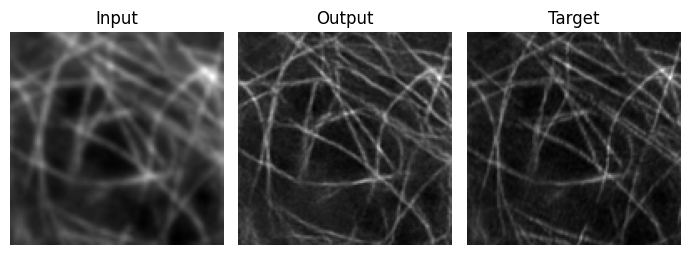

In [15]:
import time
from datetime import timedelta

epochs = 30

train_loss = []
for epoch in range(epochs):
    unet.train()

    start_time = time.time()
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    running_loss = 0.0
    for batch_idx, (input_images, target_images) in enumerate(train_loader):
        x_t, t_pos_enc, noise = prepare_data(input_images, target_images)

        outputs = unet(x=x_t, t=t_pos_enc)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(train_loader)}: "
                  f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          f"Train loss: {train_loss[-1]:.4f}, " 
          f"Time taken: {timedelta(seconds=end_time - start_time)}")

    unet.eval()
    for test_input_images, test_target_images in test_loader:
        generated_images = diffusion.reverse_diffusion(
            model=unet, n_images=1, n_channels=1,
            pos_enc_dim=pos_enc_dim, pos_enc_func=positional_encoding,
            input_image=test_input_images[:1], save_time_steps=[0],
        )
        break

    lr_image = test_input_images[0]
    image_diff_traj = generated_images[0]
    hr_generated_image = image_diff_traj[-1]
    target_image = test_target_images[0]

    fig = plt.figure(figsize=(7, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image.permute(1, 2, 0), cmap="gray")
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(hr_generated_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.title("Output")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(target_image.permute(1, 2, 0), cmap="gray")
    plt.title("Target")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()